## Analyzing Unanswered Questions

1. Install Packages
2. Tokenize
3. Emotion Analysis

### 1. Install Packages

In [37]:
# more NLP packages
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

# more data viz packages
import pyLDAvis.gensim_models
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls

2023-04-29 12:18:35.031118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
nlp = spacy.load('en_core_web_lg')

### 2.1 Test Tokenization on Subset of Data

In [51]:
# Clean stuff

small_posttext = pd.DataFrame()
small_posttext['Text'] = qcounts_1count_info['PostText'][0:100]
#qcounts_1count_info['PostText'][0:100]
small_posttext

# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    # tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    # tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    # tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
small_posttext['lemma_tokens'] = small_posttext['Text'].apply(tokenize)
small_posttext['lemma_back_to_text'] = [' '.join(map(str, l)) for l in small_posttext['lemma_tokens']]
small_posttext.head()

,Text,lemma_tokens,lemma_back_to_text
0,I have a current child support order in place ...,"[i, have, a, current, child, support, order, i...",i have a current child support order in place ...
1,My boyfriend is the non-custodial parent of hi...,"[my, boyfriend, is, the, noncustodial, parent,...",my boyfriend is the noncustodial parent of his...
2,We intially rented on ### with a ### 1st of ea...,"[we, intially, rented, on, with, a, 1st, of, e...",we intially rented on with a 1st of each month...
3,"Hello, in October of ###. She had accepted my ...","[hello, in, october, of, she, had, accepted, m...",hello in october of she had accepted my rent b...
4,I am trying to figure out the Civil Procedure ...,"[i, am, trying, to, figure, out, the, civil, p...",i am trying to figure out the civil procedure ...


In [67]:
# Test on smaller part of PostText

## tokenize
tokenizer = Tokenizer(nlp.vocab)

stop_words = open("buckley-salton.txt").read()

tokens = []

for doc in tokenizer.pipe(small_posttext['lemma_back_to_text'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in stop_words:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)
    
    
small_posttext['PostTextTokens'] = tokens
#small_posttext

In [68]:
# change everything in qcounts post text so it's a string
qcounts_1count_info['PostText'] = qcounts_1count_info['PostText'].apply(str)
qcounts_1count_info['lemma_tokens'] = qcounts_1count_info['PostText'].apply(tokenize)
qcounts_1count_info['lemma_back_to_text'] = [' '.join(map(str, l)) for l in qcounts_1count_info['lemma_tokens']]
qcounts_1count_info.head()

## tokenize
tokenizer = Tokenizer(nlp.vocab)

stop_words = open("buckley-salton.txt").read()

tokens = []

for doc in tokenizer.pipe(qcounts_1count_info['lemma_back_to_text'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in stop_words:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)
    
    
qcounts_1count_info['PostTextTokens'] = tokens

,QuestionUno,count,Id_x,StateAbbr_x,PostText,CreatedUtc,Id_y,StateAbbr_y,CategoryUno,Category,...,TakenByAttorneyUno,TakenOnUtc,ClosedByAttorneyUno,ClosedOnUtc,LegalDeadline,date,month_year,lemma_tokens,lemma_back_to_text,PostTextTokens
0,7E37427A-3974-4240-8667-B1B69A27E50D,1,333520,TX,I have a current child support order in place ...,2019-08-08 18:06:21,58811,TX,B75D4C9D-5440-4141-AD6F-E4F03FF8ADA4,Income Maintenance,...,NaN,NaN,NaN,2019-10-24 16:01:10,NaN,2019-08-08 18:05:28,2019-08-01,"[i, have, a, current, child, support, order, i...",i have a current child support order in place ...,"[child, support, order, attorney, general, off..."
1,B112866C-6324-4733-82E4-57991E1825CE,1,338614,TX,My boyfriend is the non-custodial parent of hi...,2020-05-14 20:46:43,69953,TX,CD9242A3-3478-4311-A951-F42ECB1D978D,Family and Children,...,NaN,NaN,NaN,2020-05-24 16:03:35,NaN,2020-05-14 20:46:32,2020-05-01,"[my, boyfriend, is, the, noncustodial, parent,...",my boyfriend is the noncustodial parent of his...,"[boyfriend, noncustodial, parent, daughter, st..."
2,EFA178CA-221F-4AEB-B1C8-96167E0EB2D4,1,10085,AZ,We intially rented on ### with a ### 1st of ea...,2018-07-04 00:02:42,197639,AZ,F16F6597-94E1-479C-8C06-2C95807E5412,Housing and Homelessness,...,NaN,NaN,NaN,2018-07-30 23:18:16,NaN,2018-07-04 00:02:02,2018-07-01,"[we, intially, rented, on, with, a, 1st, of, e...",we intially rented on with a 1st of each month...,"[intially, rented, 1st, month, landlord, asked..."
3,71941151-1C11-48A5-8B26-AE230CD79205,1,336690,TX,"Hello, in October of ###. She had accepted my ...",2020-02-10 22:52:32,61356,TX,A0D99ABA-B3D1-47E5-BEEF-5A7AF248E635,Housing and Homelessness,...,NaN,NaN,NaN,2020-04-23 15:59:30,2020-02-14 00:00:00,2020-02-10 22:51:50,2020-02-01,"[hello, in, october, of, she, had, accepted, m...",hello in october of she had accepted my rent b...,"[october, accepted, understood, situation, wor..."
4,AE10822C-0570-4D35-994C-00E87AFF1D8B,1,7234,AR,I am trying to figure out the Civil Procedure ...,2020-10-27 19:16:37,112972,AR,3D2FE0E6-109A-421C-BDAA-07007E23F6B5,Individual Rights,...,NaN,NaN,NaN,2020-12-03 21:33:41,NaN,2020-10-27 19:16:11,2020-10-01,"[i, am, trying, to, figure, out, the, civil, p...",i am trying to figure out the civil procedure ...,"[figure, civil, procedure, challenging, consti..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56582,20649EEC-B89C-4810-8C81-A2236BDA5103,1,275158,SC,I have ### living in a trailer for ###. He pas...,2019-04-13 05:40:35,76108,SC,2D9C7994-7716-47A4-AEEA-A07F8002D224,Other,...,NaN,NaN,NaN,2019-05-17 20:55:44,2019-04-15 00:00:00,2019-04-13 05:39:46,2019-04-01,"[i, have, living, in, a, trailer, for, he, pas...",i have living in a trailer for he passed away ...,"[living, trailer, passed, brother, bought, tra..."
56583,60953FD1-9957-47F8-A2FD-6013143CA45E,1,106207,IL,I won a civil case against the plaintiff who h...,2021-01-05 00:05:58,110393,IL,9D6B9BA4-47FE-4FEA-ABD7-7E041C0C4014,Individual Rights,...,F860CB7A-EFEA-4D8E-98D5-AE284D2DA99A,2021-01-09 21:41:11,F860CB7A-EFEA-4D8E-98D5-AE284D2DA99A,2021-01-19 21:52:35,2021-03-11 00:00:00,2021-01-05 00:05:15,2021-01-01,"[i, won, a, civil, case, against, the, plainti...",i won a civil case against the plaintiff who h...,"[civil, case, plaintiff, moved, back, illinois..."
56584,D5C9CD4D-F81A-4417-AABA-EA38D2CFF050,1,106206,IL,"my name is ### ###, I recently had talked with...",2021-01-04 21:40:57,110392,IL,35F8A400-7E66-4F6E-A692-99DF0502067A,Family and Children,...,NaN,NaN,NaN,2021-01-11 18:56:03,2021-02-05 00:00:00,2021-01-04 21:40:41,2021-01-01,"[my, name, is, i, recently, had, talked, with,...",my name is i recently had talked with your tea...,"[recently, talked, team, months, ago, guys, pr..."
56585,4E96632A-98A5-46C8-8C60-0F82B15FF108,1,106198,IL,"I have a ###, we broke up and she lets me see ...",2021-01-04 20:27:56,110390,IL,35F8A400-7E66-4F6E-A692-99DF0502067A,Family and Children,...,BC34BF04-9D4D-4E9B-9669-A4B

In [69]:
qcounts_1count_info.head()

,QuestionUno,count,Id_x,StateAbbr_x,PostText,CreatedUtc,Id_y,StateAbbr_y,CategoryUno,Category,...,TakenByAttorneyUno,TakenOnUtc,ClosedByAttorneyUno,ClosedOnUtc,LegalDeadline,date,month_year,lemma_tokens,lemma_back_to_text,PostTextTokens
0,7E37427A-3974-4240-8667-B1B69A27E50D,1,333520,TX,I have a current child support order in place ...,2019-08-08 18:06:21,58811,TX,B75D4C9D-5440-4141-AD6F-E4F03FF8ADA4,Income Maintenance,...,NaN,NaN,NaN,2019-10-24 16:01:10,NaN,2019-08-08 18:05:28,2019-08-01,"[i, have, a, current, child, support, order, i...",i have a current child support order in place ...,"[child, support, order, attorney, general, off..."
1,B112866C-6324-4733-82E4-57991E1825CE,1,338614,TX,My boyfriend is the non-custodial parent of hi...,2020-05-14 20:46:43,69953,TX,CD9242A3-3478-4311-A951-F42ECB1D978D,Family and Children,...,NaN,NaN,NaN,2020-05-24 16:03:35,NaN,2020-05-14 20:46:32,2020-05-01,"[my, boyfriend, is, the, noncustodial, parent,...",my boyfriend is the noncustodial parent of his...,"[boyfriend, noncustodial, parent, daughter, st..."
2,EFA178CA-221F-4AEB-B1C8-96167E0EB2D4,1,10085,AZ,We intially rented on ### with a ### 1st of ea...,2018-07-04 00:02:42,197639,AZ,F16F6597-94E1-479C-8C06-2C95807E5412,Housing and Homelessness,...,NaN,NaN,NaN,2018-07-30 23:18:16,NaN,2018-07-04 00:02:02,2018-07-01,"[we, intially, rented, on, with, a, 1st, of, e...",we intially rented on with a 1st of each month...,"[intially, rented, 1st, month, landlord, asked..."
3,71941151-1C11-48A5-8B26-AE230CD79205,1,336690,TX,"Hello, in October of ###. She had accepted my ...",2020-02-10 22:52:32,61356,TX,A0D99ABA-B3D1-47E5-BEEF-5A7AF248E635,Housing and Homelessness,...,NaN,NaN,NaN,2020-04-23 15:59:30,2020-02-14 00:00:00,2020-02-10 22:51:50,2020-02-01,"[hello, in, october, of, she, had, accepted, m...",hello in october of she had accepted my rent b...,"[october, accepted, understood, situation, wor..."
4,AE10822C-0570-4D35-994C-00E87AFF1D8B,1,7234,AR,I am trying to figure out the Civil Procedure ...,2020-10-27 19:16:37,112972,AR,3D2FE0E6-109A-421C-BDAA-07007E23F6B5,Individual Rights,...,NaN,NaN,NaN,2020-12-03 21:33:41,NaN,2020-10-27 19:16:11,2020-10-01,"[i, am, trying, to, figure, out, the, civil, p...",i am trying to figure out the civil procedure ...,"[figure, civil, procedure, challenging, consti..."


In [71]:
# Figure out which words are the most popular?? But these are only for qcounts with one response
from collections import Counter

word_counts = Counter(word for row in qcounts_1count_info['PostTextTokens'] for word in row)
top_20_words = word_counts.most_common(20)

top_20_words

[('court', 25786),
 ('child', 18712),
 ('back', 16810),
 ('told', 15803),
 ('case', 15784),
 ('pay', 15333),
 ('dont', 14161),
 ('home', 14057),
 ('legal', 12908),
 ('custody', 12651),
 ('file', 12498),
 ('order', 11925),
 ('house', 11341),
 ('support', 11332),
 ('work', 11155),
 ('father', 11054),
 ('money', 10874),
 ('attorney', 10852),
 ('divorce', 9685),
 ('due', 9664)]

In [ ]:
# looking at the relationship between the way the question is phrased or sentiment of the question to see if it has anything with how long it takes for someone to respnod

### 2.2 Tokenize All Unanswered Questions

In [243]:
import nltk
from nltk.corpus import stopwords
import string
from nrclex import NRCLex

In [74]:
qposts['PostText'] = qposts['PostText'].apply(str)
qposts['lemma_tokens'] = qposts['PostText'].apply(tokenize)
qposts['lemma_back_to_text'] = [' '.join(map(str, l)) for l in qposts['lemma_tokens']]
# qposts.head()

## tokenize
tokenizer = Tokenizer(nlp.vocab)

stop_words = open("buckley-salton.txt").read()

tokens = []

for doc in tokenizer.pipe(qposts['lemma_back_to_text'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in stop_words:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)
    
    
qposts['PostTextTokens'] = tokens

### 3. Emotion Analysis

In [251]:
#emotion = qposts[qposts['StateAbbr']=="AZ"]['lemma_back_to_text'].apply(NRCLex)

my_list = [str(x) for x in qposts[qposts['StateAbbr']=="AZ"]['lemma_back_to_text']]
combined_string = ''.join(my_list)
emotion = NRCLex(combined_string)

In [261]:
emotion_df = pd.DataFrame.from_dict(emotion.raw_emotion_scores.items())
emotion_df.columns = ['emotion', 'score']

alt.Chart(emotion_df).mark_bar().encode(
    x='emotion',
    y='score'
)

alt.Chart(...)

In [262]:
emotion_df

,emotion,score
0,anticipation,19455
1,joy,10962
2,positive,33134
3,trust,25985
4,fear,17742
5,negative,22849
6,sadness,13467
7,anger,13885
8,disgust,5822
9,surprise,5814


NameError: name 'pal_plas' is not defined

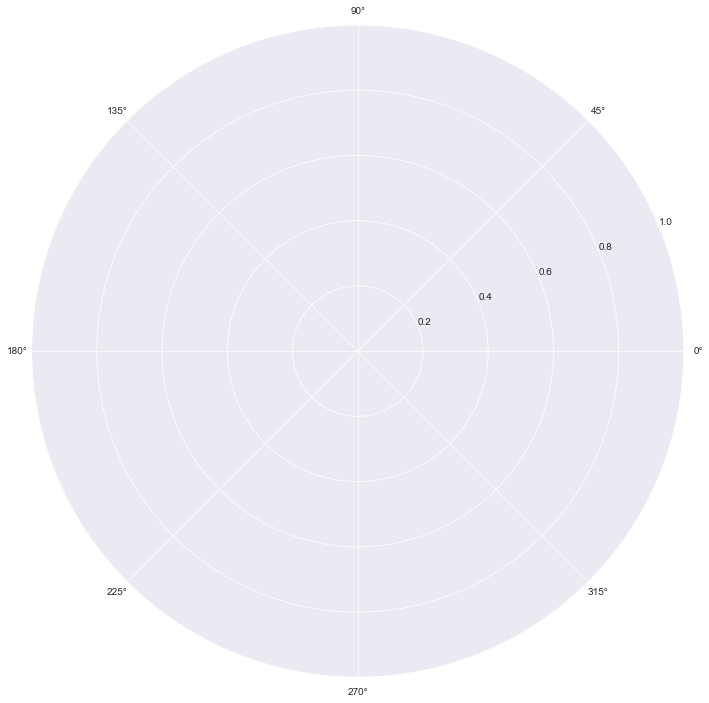

In [266]:
import matplotlib.pyplot as plt
import math
plt.gcf().set_size_inches(12, 12)
sns.set_style('darkgrid')

#set max value
max_val = max(emotion_df['emotion'])
ax = plt.subplot(projection='polar')

for i in range(len(emotion_df)):
    ax.barh(i, list(emotion_df['emotion'])[i],
            label=list(emotion_df['score'])[i], color=pal_plas[i])

#set the subplot 
ax.set_theta_zero_location('N')
ax.set_theta_direction(1)
ax.set_rlabel_position(0)
ax.set_thetagrids([], labels=[])
ax.set_rgrids(range(len(df)), labels= emotion_df['emotion'])

#set the projection
ax = plt.subplot(projection='polar')
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show()

In [ ]:
fig, ax = plt.subplots()

angles = np.linspace(0, 2*np.pi, len(values), endpoint=False)

bars = ax.bar(angles, values, width=0.5)

ax.set_xticks(angles)
ax.set_xticklabels(labels)

ax.set_ylim(0, max(values)+5)

ax.legend(bars, labels)

plt.show()

In [79]:
qposts_tokens = qposts[['Id', 'StateAbbr', 'PostText', 'CreatedUtc', 'PostTextTokens']]
qposts_tokens

,Id,StateAbbr,PostText,CreatedUtc,PostTextTokens
0,1,AK,Do you still need help with this issue? It ha...,2018-04-25 18:09:30,"[issue, posted]"
1,2,AK,Anyone?,2018-04-17 21:15:28,[]
2,3,AK,"Yes, those are the right forms. I'm sorry, I ...",2018-04-18 17:51:41,"[forms, didnt, notification, question, today, ..."
3,4,AK,"Hi ###,You do make some good points. The diff...",2018-04-18 22:15:44,"[make, good, points, difference, stocks, bonds..."
4,5,AK,My father passed away and I have DNA test resu...,2018-04-12 10:52:50,"[father, passed, dna, test, results, sisters, ..."
...,...,...,...,...,...
365190,405558,WY,I purchased carpet and flooring from Frontier ...,2022-01-03 23:10:00,"[purchased, carpet, flooring, frontier, furnit..."
365191,405560,WY,Thank you so much!! I appreciate your reply.,2022-01-04 17:37:11,[reply]
365192,405562,WY,"Hi ###,It seems like you basically have two qu...",2022-01-05 17:27:27,"[basically, questions, allowed, access, sons, ..."
365193,405563,WY,Iâ€™m in the beginning stages of getting a div...,2022-01-07 01:02:48,"[beginning, stages, divorce, lawyer, decided, ..."


In [89]:
word_counts = Counter(word for row in qposts_tokens['PostTextTokens'] for word in row)
top_50_words = word_counts.most_common(50)

top_50_words

[('court', 190439),
 ('child', 101474),
 ('legal', 96000),
 ('case', 92632),
 ('file', 92567),
 ('attorney', 92424),
 ('order', 82155),
 ('pay', 76337),
 ('dont', 71505),
 ('landlord', 65134),
 ('back', 64997),
 ('property', 61434),
 ('custody', 60165),
 ('support', 59970),
 ('information', 57977),
 ('lawyer', 56829),
 ('home', 54830),
 ('divorce', 54684),
 ('make', 52825),
 ('told', 52607),
 ('law', 50346),
 ('money', 50091),
 ('father', 48714),
 ('work', 48490),
 ('house', 47494),
 ('county', 45564),
 ('question', 44830),
 ('judge', 44808),
 ('state', 43118),
 ('children', 42513),
 ('contact', 41502),
 ('filed', 41244),
 ('find', 40238),
 ('good', 38744),
 ('family', 38099),
 ('agreement', 37375),
 ('due', 37366),
 ('husband', 36165),
 ('rights', 35816),
 ('notice', 35632),
 ('mother', 35514),
 ('hearing', 34100),
 ('live', 34097),
 ('paid', 33307),
 ('car', 32987),
 ('daughter', 32656),
 ('call', 31792),
 ('situation', 31375),
 ('didnt', 29459),
 ('date', 29355)]